## Clean data

Clean data from bronze and save into silver

In [1]:
import importlib
import os
import polars as pl
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt

from pattern_detector import utils

importlib.reload(utils)

<module 'pattern_detector.utils' from '/home/zach/Projects/PutAnalysis/pattern_detector/utils.py'>

### List of files

In [2]:
bronze_path = os.path.join("data", "bronze")
filenames = os.listdir(bronze_path)

nrdy_path = os.path.join("data", "NRDY.csv")


### Analyzing time ranges of files

##### Checking last dates of files

In [3]:
last_timestamps = {}
for filename in filenames:
    ticker = filename.removesuffix(".csv")

    # read file into df
    filepath = os.path.join(bronze_path, filename)
    df = pl.read_csv(filepath)

    # make dict of last timestamps of each ticker
    last_timestamp = df["timestamp"][-1]
    if last_timestamp in last_timestamps:
        last_timestamps[last_timestamp].append(ticker)
    else:
        last_timestamps[last_timestamp] = [ticker]

for timestamp in last_timestamps:
    print(datetime.fromtimestamp(timestamp))
    print(last_timestamps[timestamp])
    print(len(last_timestamps[timestamp]))

    

2024-09-13 06:30:00
['SCSC', 'JAZZ', 'HUM', 'GVP', 'KW', 'AXSM', 'TNDM', 'INSG', 'DBD', 'VGR', 'TPHS', 'NGVT', 'PBF', 'SAMG', 'WHR', 'DUK', 'GRBK', 'AGM', 'PMT', 'SITC', 'INVA', 'HOFT', 'ARCB', 'RMR', 'ADMA', 'GHM', 'PDCO', 'TGEN', 'SSKN', 'IIPR', 'HIW', 'CRBP', 'COLB', 'BYFC', 'BLFS', 'MATW', 'RNR', 'LILA', 'BLD', 'PBPB', 'UTHR', 'UGI', 'FTK', 'ZM', 'AXTA', 'FMBH', 'ALKS', 'PPIH', 'TXMD', 'KOS', 'CDXS', 'F', 'MAN', 'MO', 'NMIH', 'RAMP', 'UVE', 'NE', 'OOMA', 'AMZN', 'CSCO', 'AP', 'FPI', 'DHIL', 'MWA', 'ODFL', 'GPRO', 'SIGA', 'CEVA', 'HZO', 'ARL', 'KZR', 'APPN', 'QUIK', 'LC', 'AXGN', 'FND', 'CAR', 'TSBK', 'MUR', 'ARVN', 'HCKT', 'AEE', 'GCO', 'SRI', 'FLS', 'ISDR', 'HONE', 'SIGI', 'OSK', 'CVI', 'TFSL', 'ARW', 'SWK', 'BMY', 'EPAM', 'FATE', 'ZYXI', 'PG', 'LBRDA', 'TSQ', 'AC', 'AVAV', 'AEHR', 'LAD', 'RGS', 'EVC', 'ALL', 'PHIO', 'IVR', 'RDNT', 'TLYS', 'KAI', 'ANIK', 'FIZZ', 'CHK', 'ABCB', 'AMRC', 'AES', 'GSHD', 'HDSN', 'MSA', 'ZS', 'CARG', 'SPB', 'CMI', 'GPRE', 'HBI', 'NLY', 'MCK', 'NTLA', 'E

Some tickers have only one day of data for Aug 28th, not sure why. One ticker (ACER) is missing data after Jul 18th, Yahoo has this data so potentially a bug. 20 tickers are missing the most recent day. Missing one day is fine, as I expect that they will continue to get data in the future but maybe there is some latency. For the tickers missing more than one day, I will have to remove them.

##### Checking starting dates of files

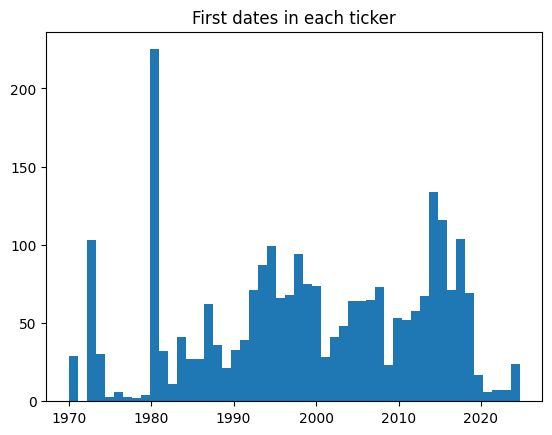

In [5]:
first_timestamps = []
for filename in filenames:
    ticker = filename.removesuffix(".csv")

    # read file into df
    filepath = os.path.join(bronze_path, filename)
    df = pl.read_csv(filepath)

    # make dict of first timestamps of each ticker
    first_timestamp = datetime.fromtimestamp(df["timestamp"][0])
    first_timestamps.append(first_timestamp)

plt.hist(first_timestamps, bins=50)
plt.title("First dates in each ticker")
plt.show()




There are many tickers that only have data for the last 10 years. We will need to remove these as well.

Setting date limits

In [6]:
most_recent_date = datetime.fromtimestamp(sorted(last_timestamps)[-1]).date()
end_required = most_recent_date - timedelta(days=1)

# start 10 years before end
start_required = date(end_required.year - 10, end_required.month, end_required.day)

print(start_required)
print(end_required)

2014-09-12
2024-09-12


### Clean files

- Require data for the last 10 years
- Reformat date column
- Combine to single parquet
- Limit to last 10 years

In [9]:
combined_df = None


tickers_removed = []
for filename in filenames:
    ticker = filename.removesuffix(".csv")
    
    # read file into df
    filepath = os.path.join(bronze_path, filename)
    df = pl.read_csv(filepath)

    # convert timestamp to date
    df = df.with_columns(pl.from_epoch(df["timestamp"], time_unit="s").dt.date().alias("date"))

    # require data for the last 10 years
    if df["date"][0] > start_required or df["date"][-1] < end_required:
        tickers_removed.append(ticker)
    else:
        # limit data to last 10 years
        df = df.filter(df["date"] > start_required)

        # rename adjclose to ticker
        df = df.rename({"adjclose": ticker})

        # remove timestamp column
        df = df.select(["date", ticker])

        # join dfs
        if combined_df is not None:
            combined_df = combined_df.join(df, on="date", how="full", coalesce=True)
        else:
            combined_df = df

print(combined_df)
print("tickers removed:", len(tickers_removed), "-", tickers_removed)


data/NRDY.csv


ColumnNotFoundError: "timestamp" not found

#### Validation

Checking for null values

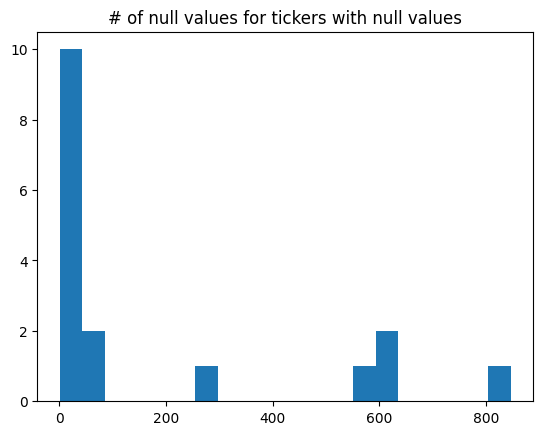

In [ ]:
def plot_nulls(df):
    null_df = df.null_count().transpose(include_header=True).sort("column_0", descending=True)

    null_df = null_df.filter(pl.col("column_0") > 0)
    plt.hist(null_df["column_0"], bins=20)
    plt.title("# of null values for tickers with null values")
    plt.show()

plot_nulls(combined_df)

Some of the columns that are missing data have a lot of data missing, but most have a small percentage of data missing. We will remove tickers with more than 5% of data missing. The rest of the nan values will be filled in as a mean.

#### Handling null values
- Require 95% not nan
- Fill nan with mean of neighbors

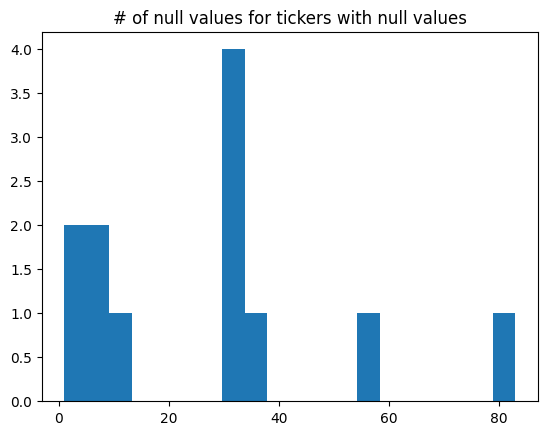

In [ ]:
# remove tickers with more than 5% missing values
thinned_df = combined_df.select(col.name for col in combined_df.null_count() / combined_df.height if col.item() < 0.05)

# check remaining column null counts
plot_nulls(thinned_df)


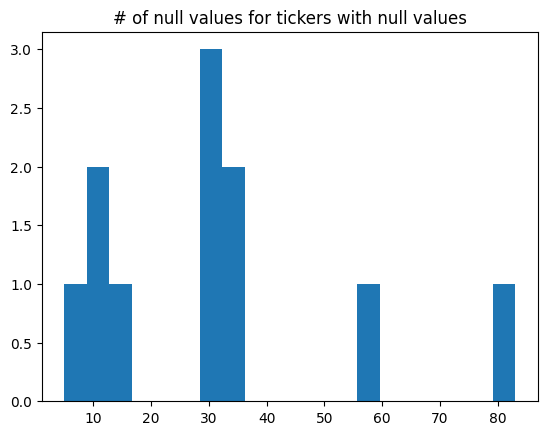

In [ ]:
filled_df = thinned_df.interpolate()

# check remaining column null counts
plot_nulls(filled_df)

At this point, the only null values are those at the start or end of the df, We can just get rid of these tickers.

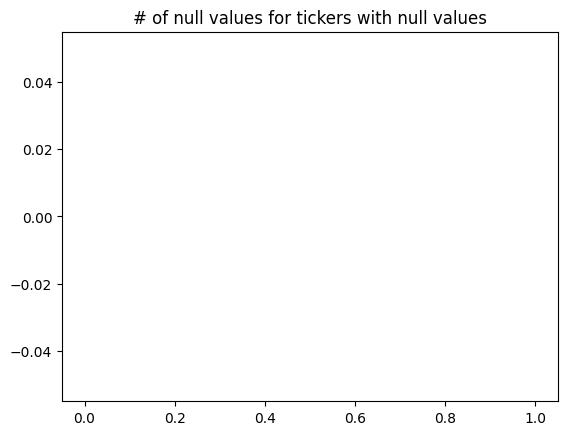

In [ ]:
cleaned_df = filled_df.select(col.name for col in filled_df.null_count() if col.item() == 0)

plot_nulls(cleaned_df)

There should be no null values remaining.

#### Calculate percent change instead of adj close

In [ ]:
percent_df = utils.convert_to_percentage(cleaned_df)

# drop first row
percent_df = percent_df[1:]

print(percent_df)

shape: (2_515, 2_110)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ SCSC      ┆ JAZZ      ┆ HUM       ┆ … ┆ APOG      ┆ BC        ┆ SNFCA     ┆ HWBK     │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ date      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2014-09-1 ┆ -0.000538 ┆ -0.012473 ┆ 0.001133  ┆ … ┆ 0.084592  ┆ 0.002705  ┆ 0.008248  ┆ 0.008148 │
│ 7         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2014-09-1 ┆ 0.009414  ┆ 0.00573   ┆ 0.00498   ┆ … ┆ 0.055204  ┆ 0.008317  ┆ 0.00818   ┆ -0.00808 │
│ 8         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ 2014-09-1 ┆ -0.026912 ┆ 0.002512  ┆ 0.01299   ┆ … ┆ -0.024478 ┆ -0.

# Calculate

#### Write to parquet

Save in data/silver/combined.parquet

In [ ]:
# write to parquet
out_filepath = os.path.join("data", "silver", "combined.parquet")
percent_df.write_parquet(out_filepath)